# Academic Performance Analytics
**Researcher:** José Kleiton  
**Methodology:** CRISP-DM (Cross-Industry Standard Process for Data Mining)

## Phase 1: Business Understanding
The objective of this project is to automate the translation of quantitative academic data into qualitative pedagogical diagnostics. The system aims to identify specific student profiles to guide intervention strategies while maintaining data privacy standards (LGPD) through a conditional anonymization layer.

### 1.1 Environment and Logging Configuration
We initialize the environment by loading configurations from the `.env` file and adjusting the working directory to ensure access to data and result folders.

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Ensure the notebook runs from the project root
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

# 1. Environment and Logging Configuration
load_dotenv()
logging.basicConfig(
    level=logging.INFO, 
    format='%(levelname)s: %(message)s'
)

# Constants and Configuration from .env
URL = os.getenv("GOOGLE_SHEET_URL")
ANONYMIZE = os.getenv("ANONYMIZE_DATA", "False").lower() == "true"

SUBJECT_MAPPING = {
    'Informática(B)': 'Informatics',
    'Lógica(B)': 'Logic',
    'Manutenção(B)': 'Maintenance'
}

%matplotlib inline
sns.set_theme(style="whitegrid")
os.makedirs("results", exist_ok=True)

## **Phase 2: Data Understanding**
In this phase, we connect to the data source (Google Sheets or local fallback). The ingestion process skips administrative headers (7 rows) and consolidates multiple subject sheets into a single structured dataset.

In [2]:
def fetch_data(url: str) -> pd.ExcelFile:
    """Consumes the spreadsheet from Google Sheets."""
    try:
        return pd.ExcelFile(url)
    except Exception as e:
        raise ConnectionError(f"Failed to access database: {e}")

def load_subjects(excel_file: pd.ExcelFile, subjects_config: dict) -> pd.DataFrame:
    """Loads, cleans, and consolidates all subject sheets."""
    dataframes = []
    for sheet_name, subject_name in subjects_config.items():
        # Skipping 7 rows as per original pedagogical template
        df = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=7, skipfooter=1)
        df['Subject'] = subject_name
        dataframes.append(df)
    
    # Cleaning: dropping rows without student names
    return pd.concat(dataframes, ignore_index=True).dropna(subset=['Nome'])

# Data Source Selection
if URL:
    data_source = fetch_data(URL)
else:
    data_source = pd.ExcelFile("data/sample_data.xlsx")

raw_df = load_subjects(data_source, SUBJECT_MAPPING)

## **Phase 3: Data Preparation**
Data preparation involves technical cleaning, scientific type conversion for grades, and the application of a privacy layer through student name anonymization.

In [3]:
def process_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    """Handles type conversion for all grade columns."""
    cols = ['3º B', '4º B', 'Média Semestral', 'Exame Final', 'Média Final']
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def anonymize_students(df: pd.DataFrame) -> pd.DataFrame:
    """Masks student names with generic IDs to comply with LGPD."""
    df = df.copy()
    unique_names = df['Nome'].unique()
    mapping = {name: f"STUDENT_{i+1:03d}" for i, name in enumerate(unique_names)}
    df['Nome'] = df['Nome'].map(mapping)
    return df

# Execution of Preparation Phase
processed_data = process_raw_data(raw_df)
final_data = anonymize_students(processed_data) if ANONYMIZE else processed_data.copy()

## **Phase 4: Modeling**
This phase applies heuristic models to categorize students into five pedagogical profiles. We calculate an interdisciplinary priority score ($Pont$) using the specific formula:$$Score = (Passes \times 3) + (Failures \times -5)$$

In [4]:
def classify_profile(row):
    """Translates quantitative data into qualitative profiles."""
    high_avg, low_avg, high_std = 7.0, 5.0, 1.5

    if row['Cont_REP'] > 0:
        return 'CRITICAL SITUATION: Student has failure(s) in the final assessment.'
    elif row['Media'] >= high_avg and row['Desv_Pad'] < high_std:
        return 'HIGH PERFORMANCE: Solid and consistent results across all subject areas.'
    elif row['Media'] >= low_avg and row['Desv_Pad'] >= high_std:
        return 'INCONSISTENT PERFORMANCE: Approved, but with significant grade fluctuation.'
    elif row['Media'] < low_avg:
        return 'GENERAL DIFFICULTY: Approved with low average, requires reinforcement of core concepts.'
    else:
        return 'STANDARD PERFORMANCE: Approved within the expected normal range.'

def generate_final_ranking(df: pd.DataFrame) -> pd.DataFrame:
    """Consolidates data into the final Ranking format."""
    grades = df.pivot(index='Nome', columns='Subject', values='Média Final')
    results = df.pivot(index='Nome', columns='Subject', values='Res. Final')
    ranking = grades.join(results, lsuffix='_Fin', rsuffix='_Res').reset_index()
    
    column_mapping = {
        'Nome': 'Aluno',
        'Informatics_Fin': 'Fin_Inf', 'Informatics_Res': 'Res_Inf',
        'Logic_Fin': 'Fin_Log', 'Logic_Res': 'Res_Log',
        'Maintenance_Fin': 'Fin_Man', 'Maintenance_Res': 'Res_Man'
    }
    ranking = ranking.rename(columns=column_mapping)

    res_cols, fin_cols = ['Res_Inf', 'Res_Log', 'Res_Man'], ['Fin_Inf', 'Fin_Log', 'Fin_Man']
    
    ranking['Cont_REP'] = (ranking[res_cols] == 'Retido (Nota)').sum(axis=1)
    ranking['Cont_APR'] = (ranking[res_cols] == 'Aprovado').sum(axis=1)
    ranking['Media'] = ranking[fin_cols].mean(axis=1).round(2)
    ranking['Desv_Pad'] = ranking[fin_cols].std(axis=1).round(2)
    ranking['Pont'] = (ranking['Cont_APR'] * 3) + (ranking['Cont_REP'] * -5)
    ranking['Perfil'] = ranking.apply(classify_profile, axis=1)
    
    final_order = ['Aluno', 'Pont', 'Media', 'Desv_Pad', 'Cont_REP', 'Cont_APR', 
                   'Fin_Inf', 'Res_Inf', 'Fin_Log', 'Res_Log', 'Fin_Man', 'Res_Man', 'Perfil']
    return ranking[final_order].sort_values(by='Pont', ascending=True)

## **Phase 5: Evaluation**
We validate the diagnostic heuristics through visual distribution reports. The charts use semantic colors and statistical annotations to represent the academic reality across subjects.

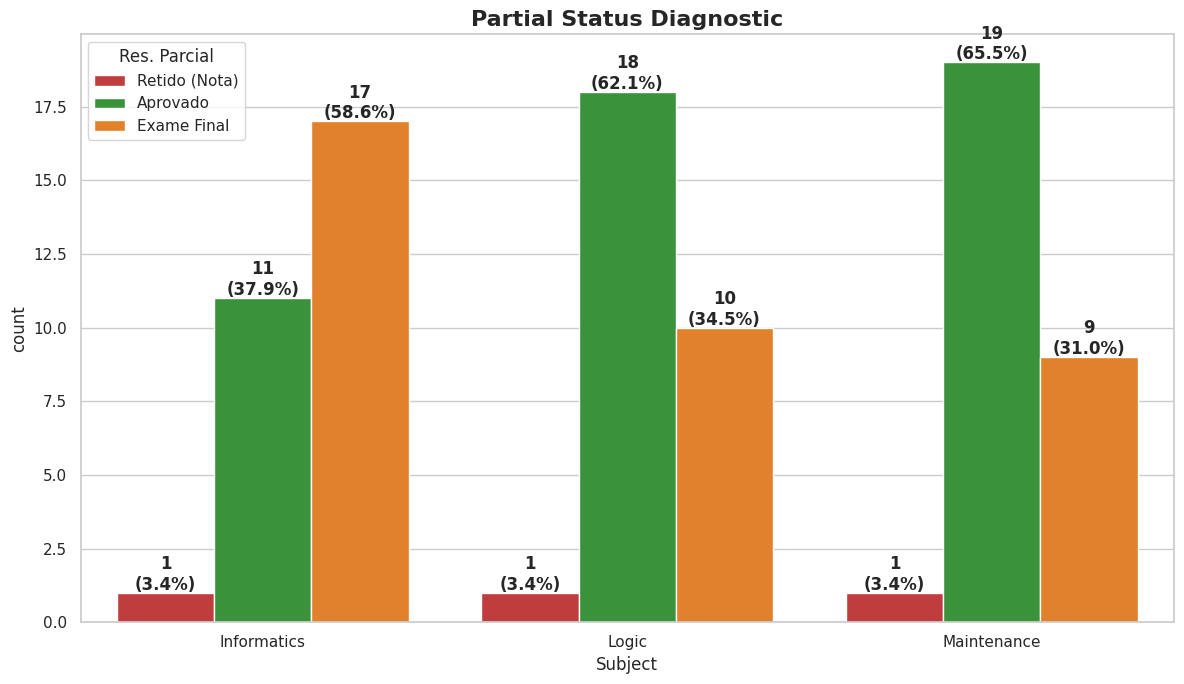

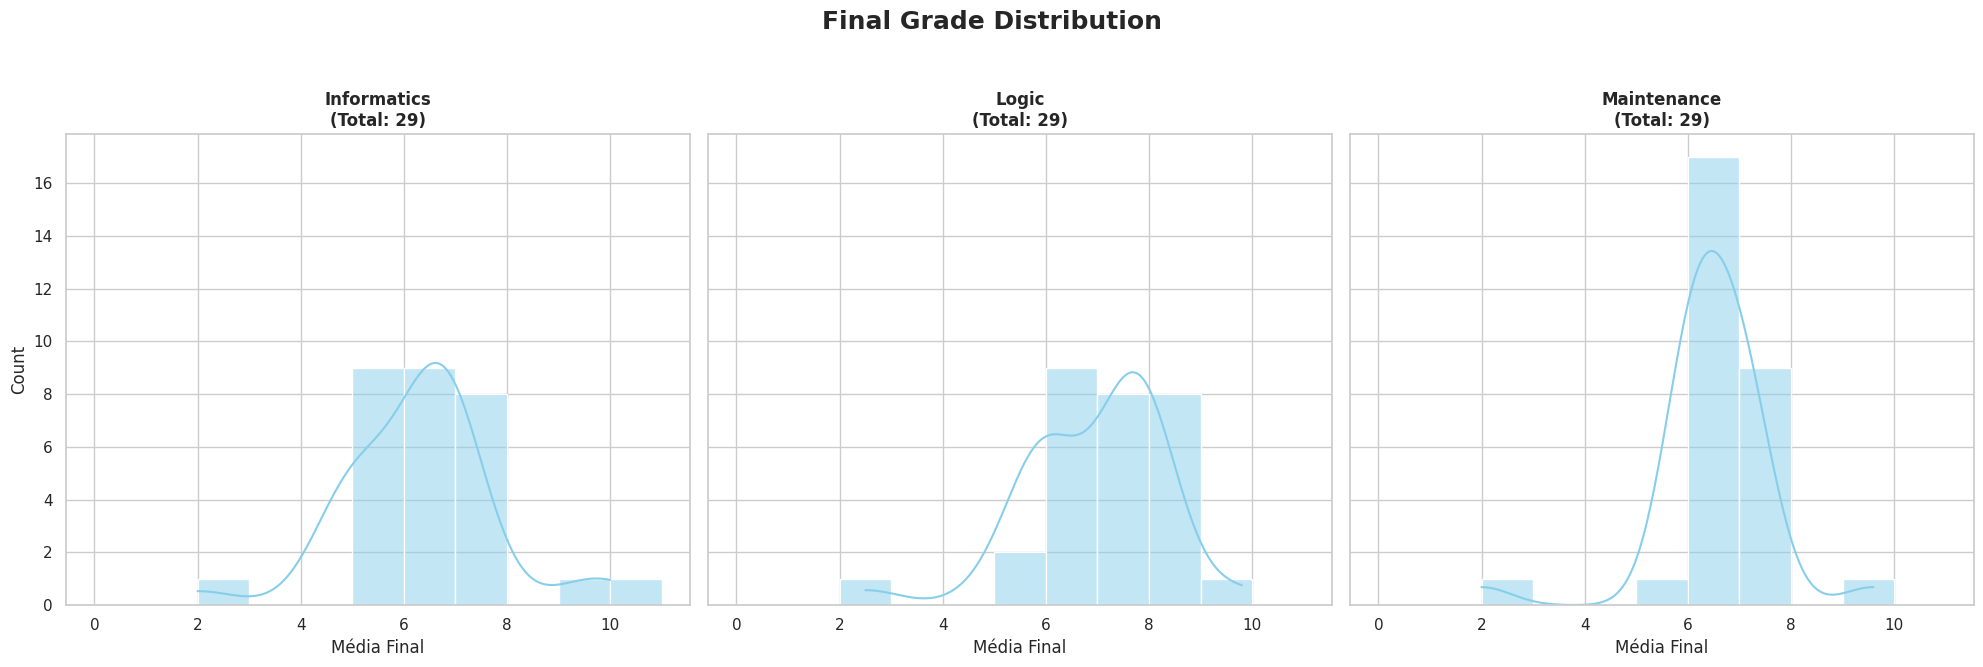

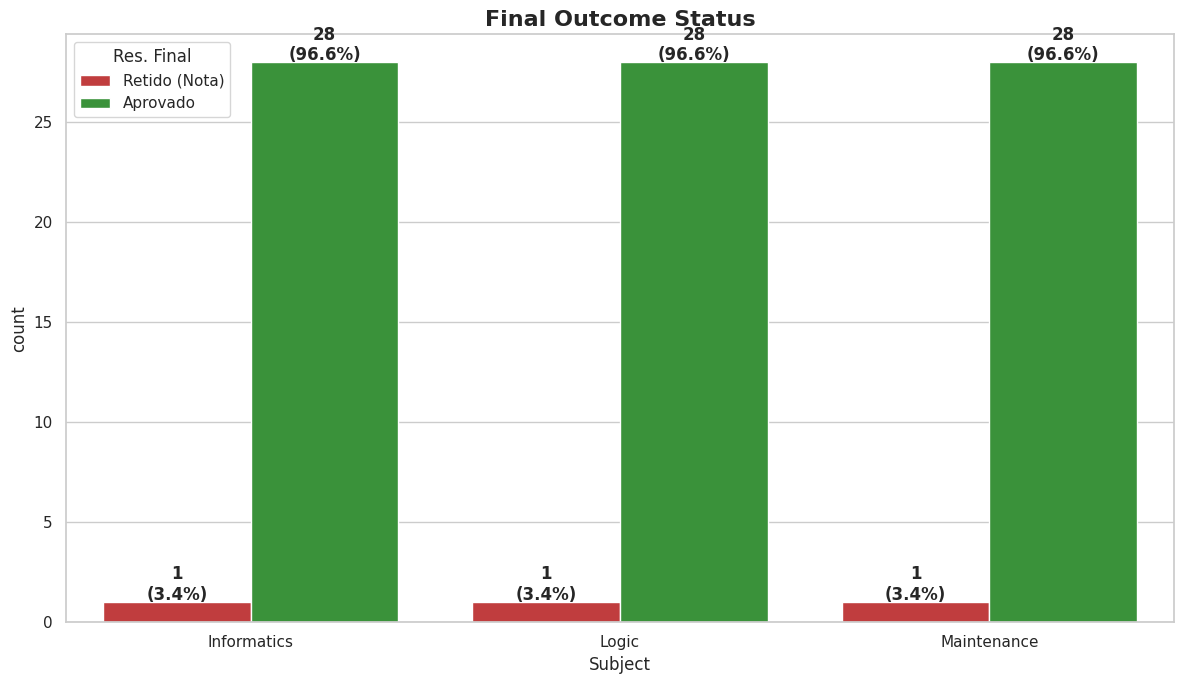

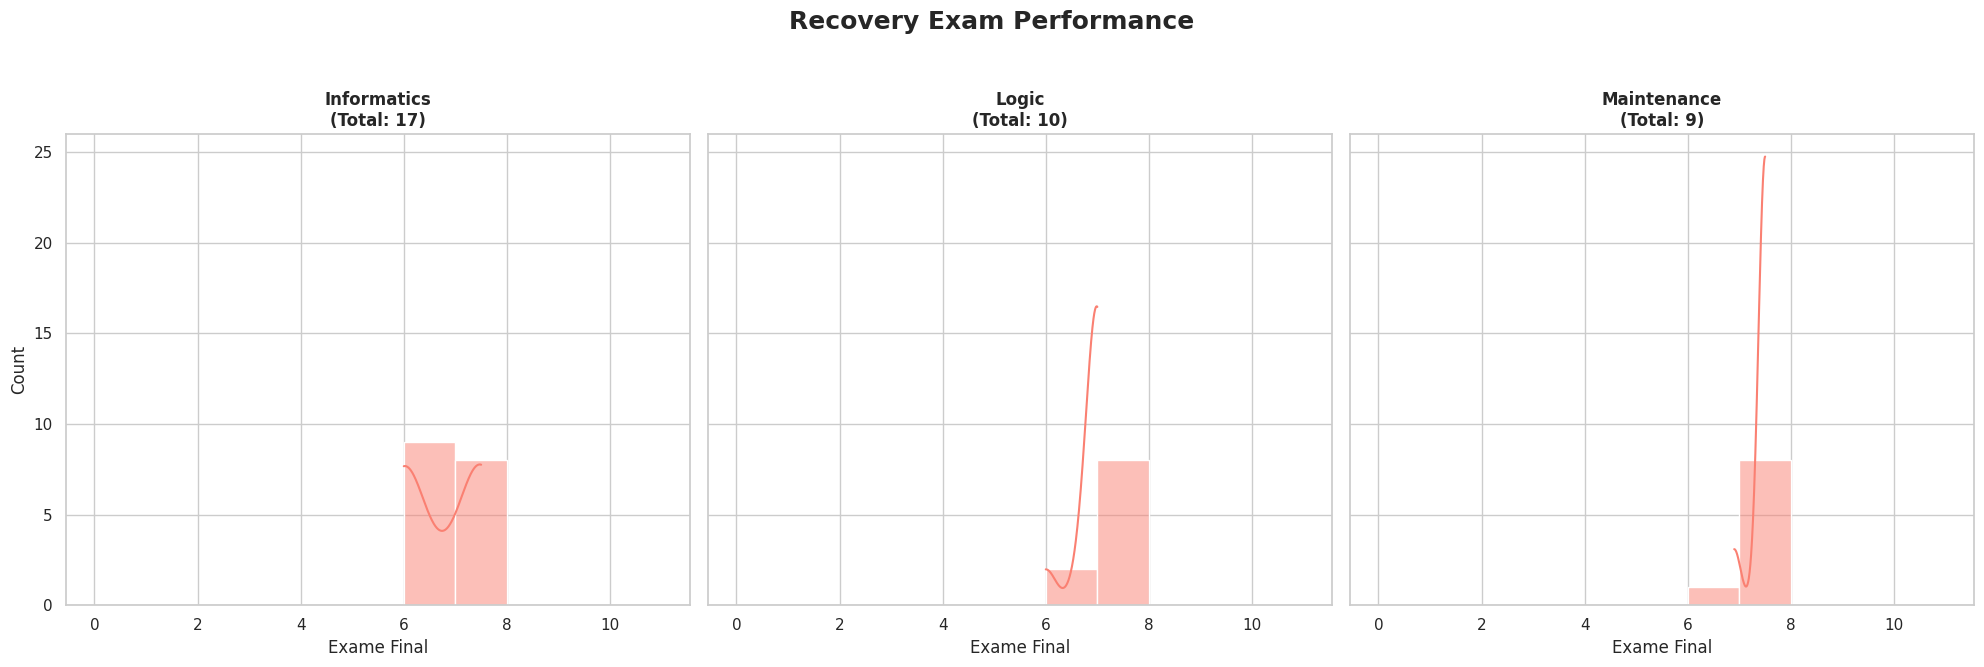

In [ ]:
def plot_status(df: pd.DataFrame, col: str, title: str, path: str):
    """Plots status distribution with semantic colors and annotations."""
    plt.figure(figsize=(12, 7))
    status_colors = {'Aprovado': '#2ca02c', 'Exame Final': '#ff7f0e', 'Retido (Nota)': '#d62728'}
    ax = sns.countplot(data=df, x='Subject', hue=col, palette=status_colors)
    plt.title(title, weight='bold', fontsize=16)
    
    total_students = len(df['Nome'].unique())
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage = 100 * height / total_students
            ax.text(p.get_x() + p.get_width()/2., height + 0.1, 
                    f'{height:.0f}\n({percentage:.1f}%)', ha="center", weight='bold')
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def plot_distributions(df: pd.DataFrame, col: str, title: str, path: str, color: str):
    """Plots histograms for grade distributions per subject."""
    subjects = df['Subject'].unique()
    if len(subjects) == 0: return
    fig, axes = plt.subplots(1, len(subjects), figsize=(20, 7), sharey=True)
    fig.suptitle(title, weight='bold', fontsize=18)
    if len(subjects) == 1: axes = [axes]
    for i, s in enumerate(subjects):
        subset = df[df['Subject'] == s]
        sns.histplot(subset[col], ax=axes[i], binwidth=1, binrange=(0,11), kde=True, color=color)
        axes[i].set_title(f"{s}\n(Total: {len(subset)})", weight='semibold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(path)
    plt.show()

# Generating all 4 Visual Reports
plot_status(final_data, 'Res. Parcial', 'Partial Status Diagnostic', 'results/1_partial_status.png')
plot_distributions(final_data, 'Média Final', 'Final Grade Distribution', 'results/2_grades_hist.png', 'skyblue')
plot_status(final_data, 'Res. Final', 'Final Outcome Status', 'results/3_final_status.png')

recovery_subset = final_data[final_data['Res. Parcial'] == 'Exame Final']
if not recovery_subset.empty:
    plot_distributions(recovery_subset, 'Exame Final', 'Recovery Exam Performance', 'results/4_recovery_hist.png', 'salmon')

## **Phase 6: Deployment**
In the final phase, the interdisciplinary ranking is exported, and a full execution summary is displayed to the user, providing the complete pedagogical report.

In [6]:
# Ranking Generation and Final Export
final_ranking = generate_final_ranking(final_data)
final_ranking.to_csv("results/final_ranking.csv", index=False)

print("\n" + "="*100)
print("PIPELINE DEPLOYMENT SUMMARY - FULL STUDENT REPORT")
print("="*100)
print(f"Privacy Mode: {'ENABLED (Anonymized Names)' if ANONYMIZE else 'DISABLED (Real Names)'}")
print(f"Total Academic Records Processed: {len(final_ranking)}")
print("-" * 100)

# Displays the full consolidated dataframe
display(final_ranking)

print("="*100)
logging.info("Deployment successful. Files saved in 'results/'.")


PIPELINE DEPLOYMENT SUMMARY - FULL STUDENT REPORT
Privacy Mode: DISABLED (Real Names)
Total Academic Records Processed: 29
----------------------------------------------------------------------------------------------------


Subject,Aluno,Pont,Media,Desv_Pad,Cont_REP,Cont_APR,Fin_Inf,Res_Inf,Fin_Log,Res_Log,Fin_Man,Res_Man,Perfil
20,Maria Silva,-15,2.17,0.29,3,0,2.0,Retido (Nota),2.5,Retido (Nota),2.0,Retido (Nota),CRITICAL SITUATION: Student has failure(s) in ...
0,Aline Guimarães,9,6.83,1.04,0,3,6.5,Aprovado,8.0,Aprovado,6.0,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
2,Ana Santos,9,7.33,2.52,0,3,10.0,Aprovado,5.0,Aprovado,7.0,Aprovado,"INCONSISTENT PERFORMANCE: Approved, but with s..."
1,Amanda Martins,9,5.83,0.76,0,3,5.0,Aprovado,6.0,Aprovado,6.5,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
4,Beatriz Gomes,9,6.83,1.04,0,3,6.5,Aprovado,8.0,Aprovado,6.0,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
5,Bruno Freitas,9,6.83,1.04,0,3,6.5,Aprovado,8.0,Aprovado,6.0,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
6,Camila Castro,9,7.23,0.25,0,3,7.0,Aprovado,7.5,Aprovado,7.2,Aprovado,HIGH PERFORMANCE: Solid and consistent results...
3,Antônio Ferreira,9,6.23,0.25,0,3,6.5,Aprovado,6.0,Aprovado,6.2,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
8,Daniela Teixeira,9,6.83,1.04,0,3,6.5,Aprovado,8.0,Aprovado,6.0,Aprovado,STANDARD PERFORMANCE: Approved within the expe...
9,Felipe Vieira,9,6.83,1.04,0,3,6.5,Aprovado,8.0,Aprovado,6.0,Aprovado,STANDARD PERFORMANCE: Approved within the expe...


INFO: Deployment successful. Files saved in 'results/'.
